In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import time
import seaborn as sns
import sklearn

[nltk_data] Downloading package stopwords to /home/xin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('StackOverflow-Dataset.csv', delimiter=";")
print(df.head(20))

                                                title   label
0               Using entries from other kivy classes  python
1    Package python software with pylucene dependency  python
2            Extracting time with regex from a string  python
3   How do I add specific headers before each form...  python
4   Barplot from a dataframe using a column to set...  python
5   python how to collect a specific file from a l...  python
6   &lt;select&gt; element is displayed with defau...  python
7   Multiple GET Requests, merge json response int...  python
8   Python SpeechRecognition mic in list_microphon...  python
9                 speech recognition not taking input  python
10  Loops Help in Python... reordering cards in a ...  python
11  Python error: input expected at most 1 argumen...  python
12  SpeechToText conversion using Python - SpeechR...  python
13        I CAN&#39;T CREATE TEMPORARY TABLE IN MYSQL  python
14  Improving Implementation of Binet&#39;s Formul...  python
15  Run 

In [3]:
wordsPreClean = df['title'].apply(lambda x: len(x.split(' '))).sum()
print(wordsPreClean , "words before cleaned")

135140 words before cleaned


In [4]:
def print_plot(index):
    example = df[df.index == index][['title', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('label:', example[1])

```
Method for clean text
```

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [6]:
print("  !before cleaned")
print_plot(51)

  !before cleaned
Creating a histogram raises: &quot;only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices&quot;
label: python


```
show the difference between cleaned and un cleand text
```

In [7]:
df['title'] = df['title'].apply(clean_text)
print("  !after cleaned")
print_plot(51)

  !after cleaned
creating histogram raises quot integers slices ellipsis numpynewaxis none integer boolean arrays valid indicesquot
label: python


In [8]:
wordsPostCLean = df['title'].apply(lambda x: len(x.split(' '))).sum()
print(wordsPostCLean)

89457


In [9]:
print('the processiung has reduced the number of words by:')
print(wordsPreClean-wordsPostCLean)
print(df)

the processiung has reduced the number of words by:
45683
                                                   title       label
0                             using entries kivy classes      python
1            package python software pylucene dependency      python
2                           extracting time regex string      python
3                add specific headers form model formset      python
4          barplot dataframe using column set bar colors      python
...                                                  ...         ...
13933                                           way loop  javascript
13934              stripe connect account id safe expose  javascript
13935  handling multiple offers different peers webrt...  javascript
13936  pixijs newbie looking advice troubleshoot text...  javascript
13937      make sticky section horizontal scroll gallery  javascript

[13938 rows x 2 columns]


```
change the label from python and javascript to 0 and 1 respectively
```

In [10]:
for row in df.index:
    if(df['label'][row] == 'python'):
        df['label'][row] = 0 #case of python 
    else:
        df['label'][row] = 1 #case of javascript
print("update the labels from python to 0 and javascript to 1 \n")
print(df)

update the labels from python to 0 and javascript to 1 

                                                   title label
0                             using entries kivy classes     0
1            package python software pylucene dependency     0
2                           extracting time regex string     0
3                add specific headers form model formset     0
4          barplot dataframe using column set bar colors     0
...                                                  ...   ...
13933                                           way loop     1
13934              stripe connect account id safe expose     1
13935  handling multiple offers different peers webrt...     1
13936  pixijs newbie looking advice troubleshoot text...     1
13937      make sticky section horizontal scroll gallery     1

[13938 rows x 2 columns]


```
Split data into train,validation,test
```

In [11]:
df = df.sample(frac=1).reset_index(drop=True) #shuffles data
train_data = df.iloc[:round(len(df.index)*0.6),:] #takes 60% for test data
train_title = train_data.title
train_label = list(train_data.label)
#if you algorithm doesn't need validation yuo can change the split to 80/20 train/test or whatever you fin to give the best results for you algorithm 

validation_data = df.iloc[round(len(df.index)*0.6):round(len(df.index)*0.8),:] #takes 20% for validation
vali_title = validation_data.title
vali_label = list(validation_data.label)

test_data = df.iloc[round(len(df.index)*0.8):round(len(df.index)),:] #takes 20% for test
test_title = test_data.title
test_label = list(test_data.label)

# print(train_data)
# print(validation_data)
# print(test_data)

```
Creates a document-term matrix using a count vector
```

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(train_title)
vectorizer.vocabulary_

train_vector  = vectorizer.transform(train_title)
train_title_temp = list(train_vector.toarray())
training = np.array(train_title_temp) # document-term matrix
output = np.array(train_label) # label

trainingTextDF = pd.DataFrame(training,columns=vectorizer.vocabulary_)
trainingLabelDF = pd.DataFrame(output,columns=["pythonORjavascript"])

# print(trainingTextDF)
# print(trainingLabelDF)

In [13]:
def hypothesis(X, theta):
    z = np.dot(theta, X.T)
    return 1/(1+np.exp(-(z))) - 0.0000001

In [14]:
def cost(X, y, theta):
    y1 = hypothesis(X, theta)
    return -(1/len(X)) * np.sum(y*np.log(y1) + (1-y)*np.log(1-y1))

In [15]:
def gradient_descent(X, y, theta, alpha, epochs):
    m =len(X)
    J = [cost(X, y, theta)] 
    for i in range(0, epochs):
        h = hypothesis(X, theta)
        for i in range(0, len(X.columns)):
            theta[i] -= (alpha/m) * np.sum((h-y)*X.iloc[:, i])
        J.append(cost(X, y, theta))
    return J, theta    

In [16]:
def predict(X, y, theta, alpha, epochs):
    J, th = gradient_descent(X, y, theta, alpha, epochs) 
    h = hypothesis(X, theta)
    for i in range(len(h)):
        h[i]=1 if h[i]>=0.5 else 0
    y = list(y)
    acc = np.sum([y[i] == h[i] for i in range(len(y))])/len(y)
    return J, acc

```
Add one extra column for the bias. This should be a column of ones because any real number remains unchanged if multiplied by one.
```

In [17]:
trainingTextDF = pd.concat([pd.Series(0, index = trainingTextDF.index, name = '00'), trainingTextDF], axis=1)
# print(trainingTextDF)

In [18]:
X = trainingTextDF
y = trainingLabelDF["pythonORjavascript"]
print(X.shape)
print(y.shape)

(8363, 8515)
(8363,)


In [19]:
theta = [0]*len(X.columns)
# theta

In [20]:
L, theta = gradient_descent(X, y, theta, 0.03, 2)
# print(L,theta)

In [21]:
predict(X, y, theta, 0.03, 3)

([0.6924960439601744,
  0.6921715329442102,
  0.6918477211208565,
  0.6915246065021596],
 0.8331938299653234)

In [22]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.005, 10)

In [37]:
print("accuracy :",acc,"with 0.005 learning rate and 10 iterations)")

accuracy : 0.8370202080593089 with 0.005 learning rate and 10 iterations)


501


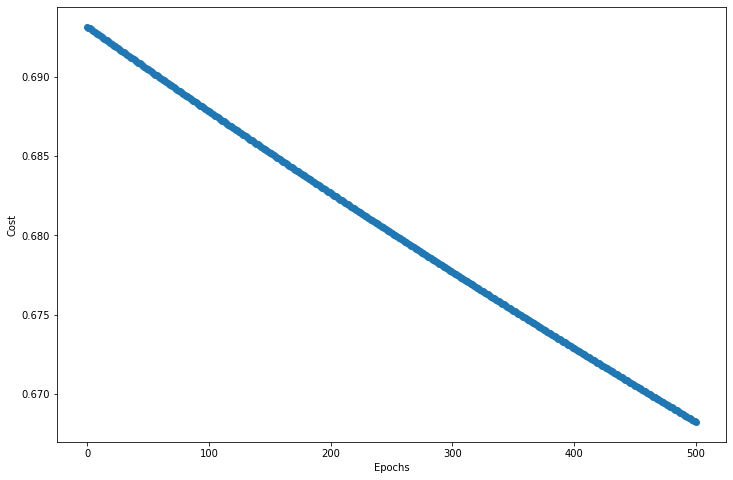

In [39]:
print(len(J))
plt.figure(figsize = (12, 8))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [25]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.0001, 100)

In [50]:
print("accuracy :",acc,"with 0.0001 learning rate and 100 iterations)")

accuracy : 0.8564764980265519 with 0.0001 learning rate and 100 iterations)


501


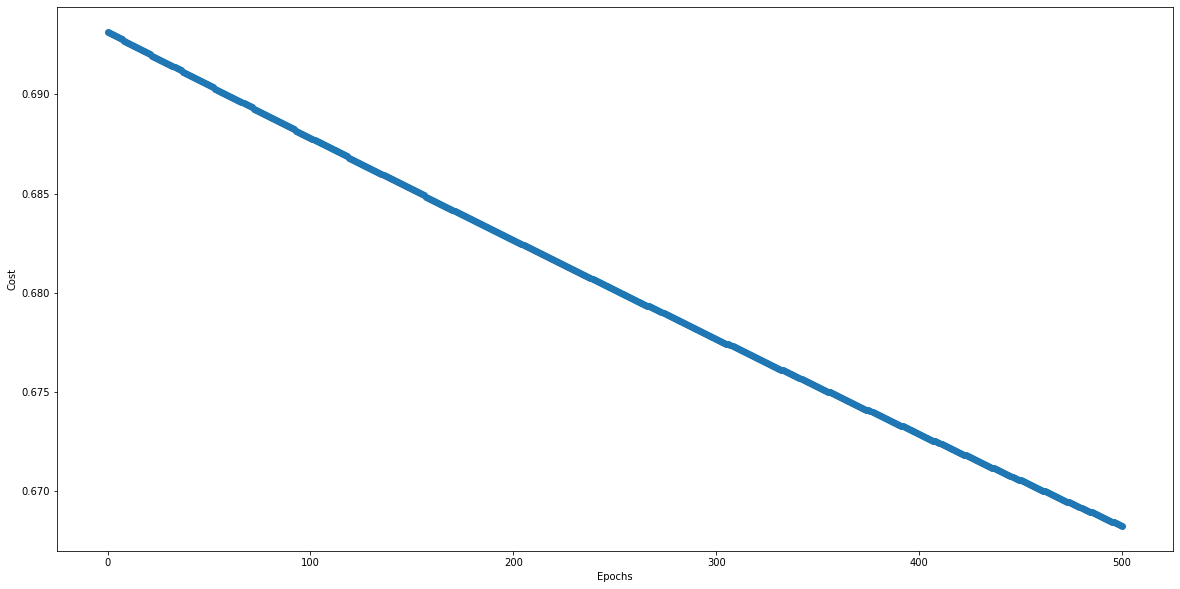

In [38]:
print(len(J))
plt.figure(figsize = (20, 10))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [28]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.005, 500)

In [35]:
print("accuracy :",acc,"with 0.005 learning rate and 500 iterations)")

accuracy : 0.8370202080593089 with 0.005 learning rate and 500 iterations)


501


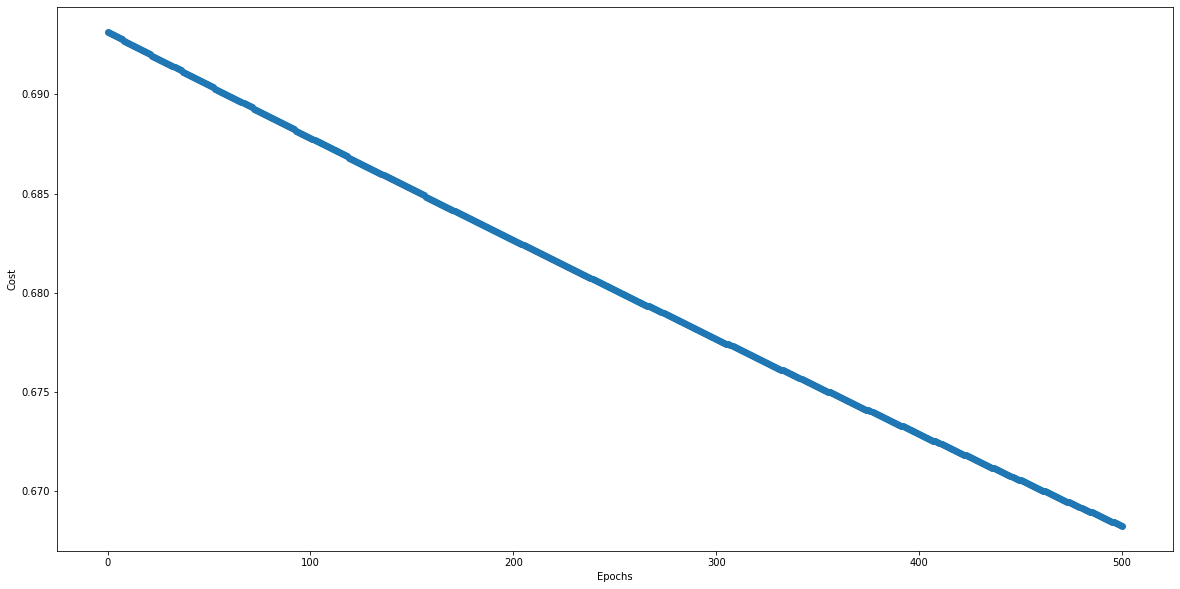

In [34]:
print(len(J))
plt.figure(figsize = (20, 10))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [44]:
vali_vector  = vectorizer.transform(vali_title)
vali_title_temp = list(vali_vector.toarray())
validating = np.array(vali_title_temp) # document-term matrix
vali_output = np.array(vali_label) # label

validatingTextDF = pd.DataFrame(validating,columns=vectorizer.vocabulary_)
validatingLabelDF = pd.DataFrame(vali_output,columns=["pythonORjavascript"])

validatingTextDF = pd.concat([pd.Series(0, index = validatingTextDF.index, name = '00'), validatingTextDF], axis=1)
# print(trainingTextDF)

X = validatingTextDF
y = validatingLabelDF["pythonORjavascript"]
print(X.shape)
print(y.shape)


(2787, 8515)
(2787,)


In [47]:
theta = [0]*len(X.columns)

L, theta = gradient_descent(X, y, theta, 0.03, 2)

predict(X, y, theta, 0.03, 3)


([0.6924724430263196,
  0.6921361983152089,
  0.6918006970154504,
  0.6914659367305807],
 0.8514531754574811)

accuracy : 0.8507355579476139 with 0.005 learning rate and 10 iterations)
11


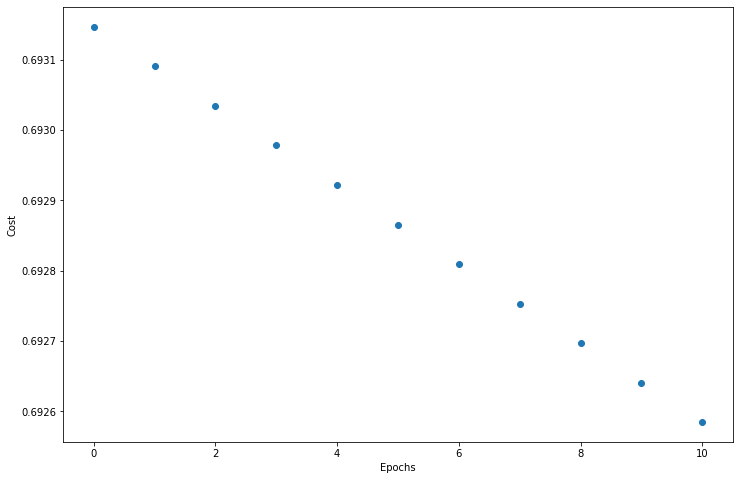

In [48]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.005, 10)

print("accuracy :",acc,"with 0.005 learning rate and 10 iterations)")

print(len(J))
plt.figure(figsize = (12, 8))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

accuracy : 0.8564764980265519 with 0.005 learning rate and 500 iterations)
501


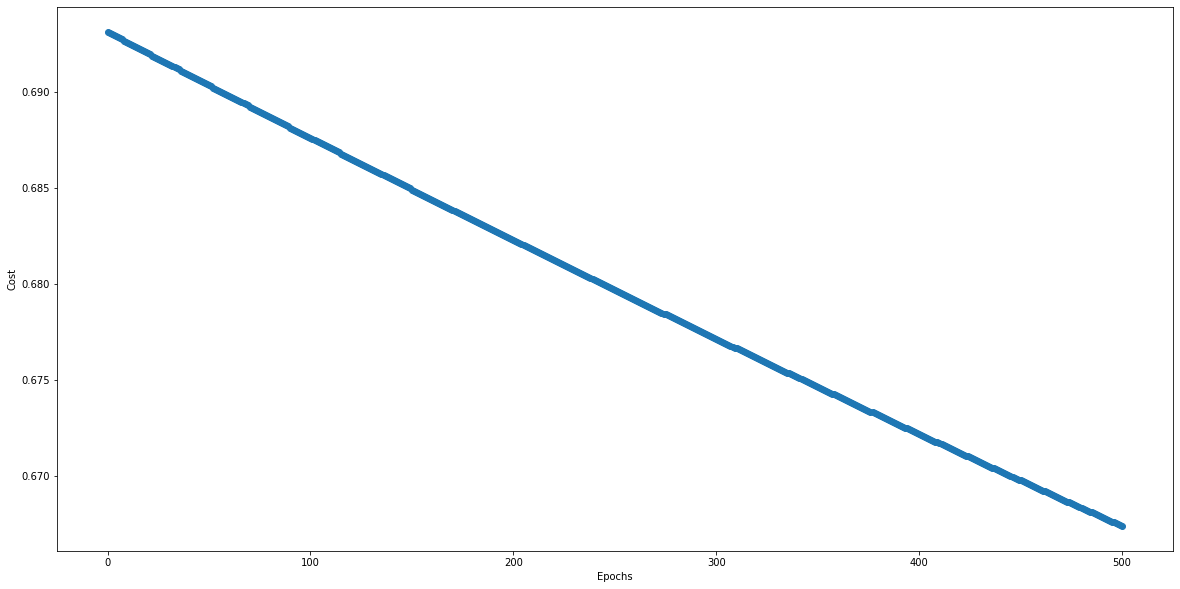

In [49]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.005, 500)

print("accuracy :",acc,"with 0.005 learning rate and 500 iterations)")

print(len(J))
plt.figure(figsize = (20, 10))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [51]:
test_vector  = vectorizer.transform(test_title)
test_title_temp = list(test_vector.toarray())
testing = np.array(test_title_temp) # document-term matrix
test_output = np.array(test_label) # label

testingTextDF = pd.DataFrame(testing,columns=vectorizer.vocabulary_)
testingLabelDF = pd.DataFrame(test_output,columns=["pythonORjavascript"])

testingTextDF = pd.concat([pd.Series(0, index = testingTextDF.index, name = '00'), testingTextDF], axis=1)
# print(trainingTextDF)

X = testingTextDF
y = testingLabelDF["pythonORjavascript"]
print(X.shape)
print(y.shape)

(2788, 8515)
(2788,)


In [52]:
theta = [0]*len(X.columns)

L, theta = gradient_descent(X, y, theta, 0.03, 2)

predict(X, y, theta, 0.03, 3)

([0.6924677634786601,
  0.692129096913641,
  0.6917911215297674,
  0.6914538355537342],
 0.8586800573888091)

accuracy : 0.8611908177905309 with 0.005 learning rate and 500 iterations)
501


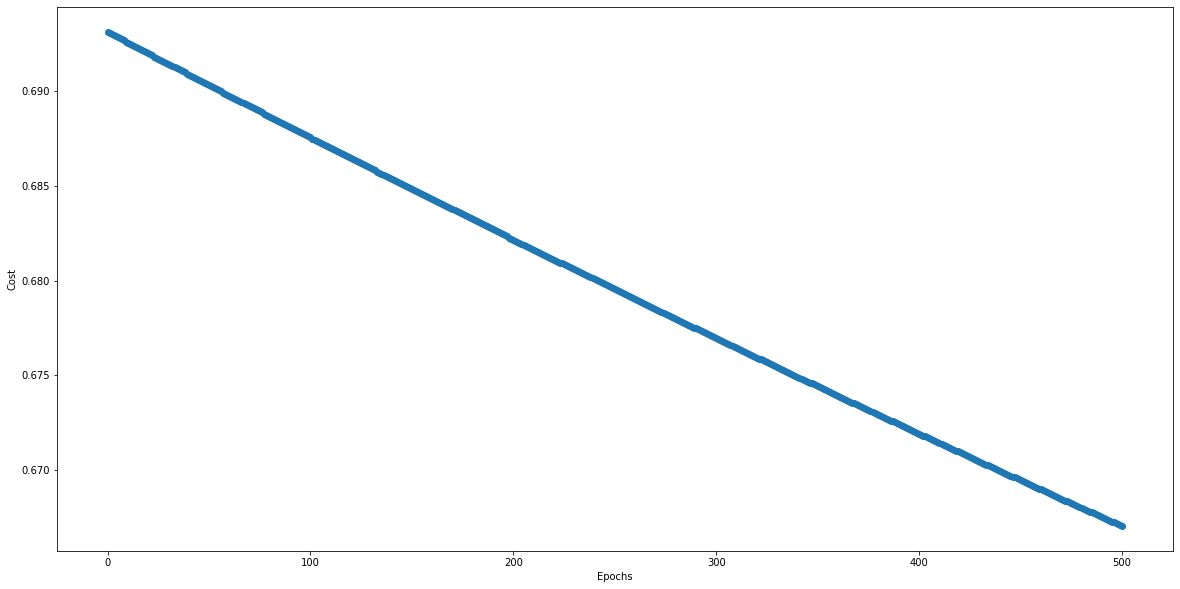

In [53]:
theta = [0]*len(X.columns)
J, acc = predict(X, y, theta, 0.005, 500)

print("accuracy :",acc,"with 0.005 learning rate and 500 iterations)")

print(len(J))
plt.figure(figsize = (20, 10))
plt.scatter(range(0, len(J)), J)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()